In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams


Теперь решаем задачу регрессии - предскажем цены на недвижимость. 
Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

Построить случайный лес, вывести важность признаков

Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [2]:
data_train = pd.read_csv('train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# разбиваем данные на train и на test
data_train_y = data_train['SalePrice'].copy()
data_train_x = data_train.drop('SalePrice', axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data_train_x, data_train_y, test_size=0.3)  

In [5]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1022, 80), (1022,), (438, 80), (438,))

In [6]:
# Соединим train и test, для удобства обработки
X_valid['is_test'] = 1
X_train['is_test'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
data = pd.concat([X_valid, X_train])

In [9]:
data.isnull().sum()[data.isnull().sum().values != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

In [11]:
# Разбиваем данные на категориальные и числовые
data_cat = data[cat_feat]

data_int = data.drop(cat_feat, axis=1)

In [12]:
# заполняем пропуски
data[data_cat.columns] = data_cat[data_cat.columns].fillna('NaN')
data[data_int.columns] = data[data_int.columns].fillna(0)

In [13]:
data.isnull().sum()[data.isnull().sum().values != 0]

Series([], dtype: int64)

In [14]:
# Обрабатываем категориальные переменные (при предположении что в test будут отличные значения,следовало бы обучаться только на train)
# Так же для каждого признака нужно было бы создать LabelEncoder, но в нашем примере можно этого не делать
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in data_cat.columns:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [15]:
data.head(3)

,Id,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,...,MiscFeature_NaN,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
698,699,20,65.0,8450,19,5,2,2,5,8,...,1,0,0,0,0,0,0,0,1,0
912,913,30,51.0,6120,3,2,2,2,5,7,...,0,0,1,0,1,0,0,0,0,0
1014,1015,20,60.0,11664,12,0,2,2,6,5,...,1,0,0,0,0,0,0,0,1,0


In [16]:
# делим данные на трейн и тест
X_train = data[data.is_test==0]
X_valid = data[data.is_test==1]

X_train = X_train.drop('is_test', axis=1)
X_valid = X_valid.drop('is_test', axis=1)

In [17]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1022, 215), (1022,), (438, 215), (438,))

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
clf_rf = RandomForestRegressor(n_jobs=-1, n_estimators=200)
max_depth = [5, 9, 13, 15]
min_samples_split = [10, 15, 25]
param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

clf_rf = GridSearchCV(clf_rf, param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 9, 13, 15],
                         'min_samples_split': [10, 15, 25]},
             scoring='neg_mean_squared_error')

In [20]:
clf_rf_best = clf_rf.best_estimator_

In [21]:
y_pred_rf = clf_rf_best.predict(X_valid)

In [22]:
# Оценка по RandomForestRegressor
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_valid, y_pred_rf)
lin_rmse_rf = np.sqrt(lin_mse)
lin_rmse_rf

37624.39330126152

In [23]:
# Выводим важность признаков (TOP-5) 
imp = pd.Series(clf_rf_best.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False).head()

OverallQual    0.580173
GrLivArea      0.098686
TotalBsmtSF    0.055061
GarageArea     0.044108
BsmtFinSF1     0.027972
dtype: float64

In [24]:
from sklearn.model_selection import StratifiedKFold

In [25]:
cv = StratifiedKFold(n_splits=10)

In [26]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float) 
    meta_test = np.zeros(X_test.shape[0], dtype=float) 
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)): 
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [27]:
from sklearn.linear_model import Lasso
lin_reg = Lasso()

In [28]:
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.]}
lasso_grid = GridSearchCV(lin_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [29]:
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1.0]},
             scoring='neg_mean_squared_error')

In [30]:
lasso_grit_best = lasso_grid.best_estimator_

In [31]:
y_pred_lasso = lasso_grit_best.predict(X_valid)

In [32]:
lin_mse = mean_squared_error(y_valid, y_pred_lasso)
rmse_lasso = np.sqrt(lin_mse)
rmse_lasso

50040.76806393125

In [33]:
clf_rf_best = clf_rf.best_estimator_

In [34]:
y_pred_rf = clf_rf_best.predict(X_valid)

In [35]:
lin_mse = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(lin_mse)
rmse_rf

37624.39330126152

In [36]:
import xgboost as xgb

In [37]:
xgb_model_2 = xgb.XGBRegressor(n_estimators=30, n_jobs=-1)

In [38]:
xgb_model_final = xgb.XGBRegressor(colsample_bytree=1, gamma=0, max_depth=5, reg_alpha=0.6, reg_lambda=0.1,
                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.01)

In [39]:
xgb_model_final.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0.6, reg_lambda=0.1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred_xgb = xgb_model_final.predict(X_valid)

In [41]:
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))
rmse_xgb

41200.89263323923

In [42]:
all_models = [lasso_grit_best, clf_rf_best, xgb_model_final]

In [43]:
meta_train = []
meta_test = []
for i in all_models:
    meta_tr, meta_te = get_meta_features(i, X_train, y_train, X_valid, cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)

    
col_names = ['lasso_model', 'rf_model', 'xgb_model']

In [44]:
X_train_meta = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_test_meta = pd.DataFrame(np.stack(meta_test,axis=1), columns=col_names)

In [45]:
X_train_meta.head(3)

,lasso_model,rf_model,xgb_model
0,234684.018252,192050.475339,214470.671875
1,89577.027488,107104.130395,110679.125000
2,123040.845428,130380.999084,126074.492188


In [46]:
from sklearn.linear_model import LinearRegression
clf_lr_meta = LinearRegression(n_jobs=-1)

In [47]:
clf_lr_meta.fit(X_train_meta, y_train)

LinearRegression(n_jobs=-1)

In [48]:
yl_pred_meta_test = clf_lr_meta.predict(X_test_meta)

In [49]:
lin_mse = mean_squared_error(y_valid, yl_pred_meta_test)
rmse_stack = np.sqrt(lin_mse)
rmse_stack

44308.020893201036

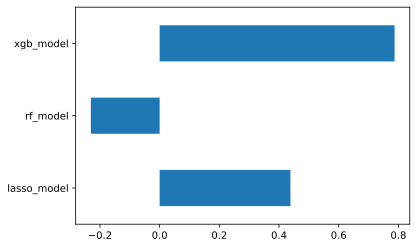

In [50]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_train_meta.columns).plot(kind='barh')

In [51]:
print ('Результат lasso_reg',rmse_lasso)
print ('Результат Lasso RandomForest',rmse_rf)
print ('Результат XGBoost',rmse_xgb)
print ('Результат stacking',rmse_stack)

Результат lasso_reg 50040.76806393125
Результат Lasso RandomForest 37624.39330126152
Результат XGBoost 41200.89263323923
Результат stacking 44308.020893201036
